In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier   
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("K:/Computer Science/AIMLDL/Brand_Reputation_Management_System/sentiment_analysis/data_preprocessing/processed_dataset.csv")
df = df.dropna(subset=['cleaned_review', 'sentiment'])

In [17]:
label_encoder = LabelEncoder()
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])
print(label_encoder.classes_)

['female' 'male' 'prefer not to say']


In [4]:
X = df[['cleaned_review', 'age', 'gender_encoded']]
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
tfidf = TfidfVectorizer(max_features=5000, min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf.transform(X_test['cleaned_review'])

# Combine
X_train_combined = hstack((X_train_tfidf, np.array(X_train[['age', 'gender_encoded']])))
X_test_combined = hstack((X_test_tfidf, np.array(X_test[['age', 'gender_encoded']])))

# Scale
scaler = StandardScaler(with_mean=False)
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

# Encode
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [6]:
X_train_tfidf.shape

(307463, 5000)

In [7]:
y_train_encoded.shape

(307463,)

In [18]:
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [11]:
models = {
    'XGBClassifier': XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=200, eval_metric='mlogloss'),
    'Logistic Regression': LogisticRegression(C=0.01, solver='liblinear'),
    'Naive Bayes': MultinomialNB(alpha=10.0),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth=None),
    'Random Forest': RandomForestClassifier(max_depth=None, min_samples_split=5, n_estimators=200, n_jobs=-1),
}


Evaluating XGBClassifier:
XGBClassifier Cross-Validation Accuracy: 0.8704 (+/- 0.0007)
XGBClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.68      9800
           1       0.44      0.07      0.12      5690
           2       0.89      0.98      0.94     61376

    accuracy                           0.87     76866
   macro avg       0.69      0.56      0.58     76866
weighted avg       0.84      0.87      0.84     76866



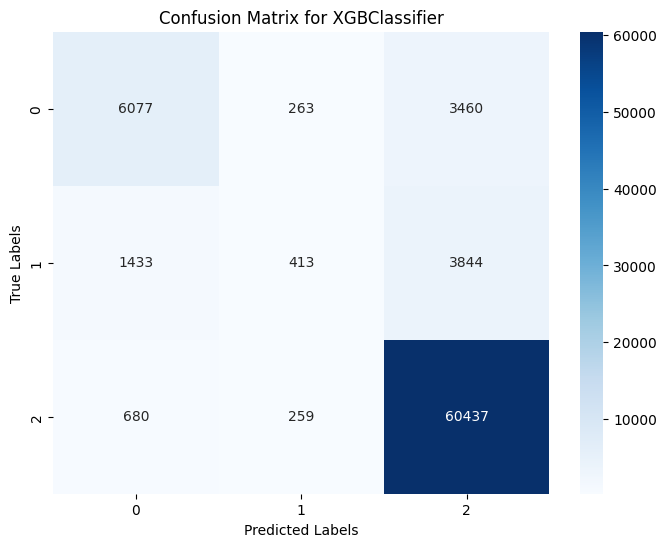


Evaluating Logistic Regression:
Logistic Regression Cross-Validation Accuracy: 0.8786 (+/- 0.0007)
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      9800
           1       0.41      0.13      0.20      5690
           2       0.92      0.97      0.95     61376

    accuracy                           0.88     76866
   macro avg       0.68      0.61      0.62     76866
weighted avg       0.85      0.88      0.86     76866



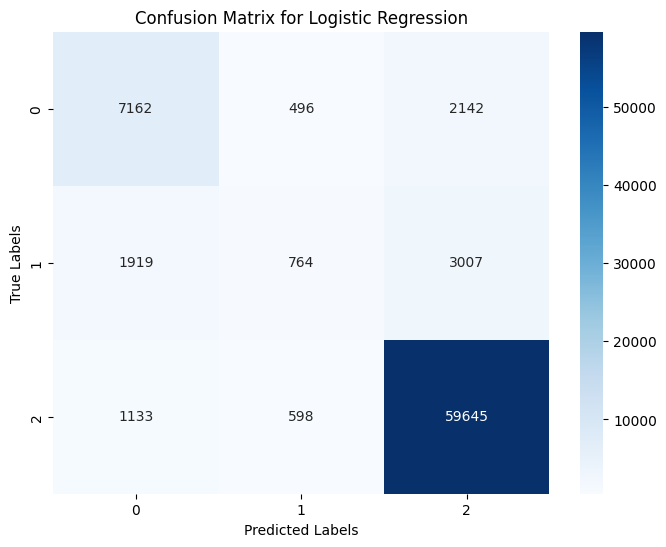


Evaluating Naive Bayes:
Naive Bayes Cross-Validation Accuracy: 0.7615 (+/- 0.0013)
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.61      0.57      9800
           1       0.23      0.54      0.32      5690
           2       0.96      0.81      0.88     61376

    accuracy                           0.77     76866
   macro avg       0.57      0.65      0.59     76866
weighted avg       0.85      0.77      0.80     76866



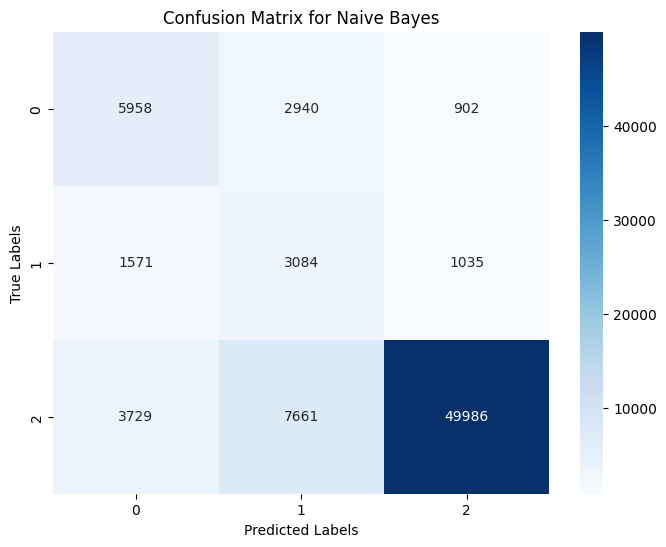


Evaluating Decision Tree:
Decision Tree Cross-Validation Accuracy: 0.8176 (+/- 0.0012)
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      9800
           1       0.22      0.17      0.19      5690
           2       0.91      0.92      0.91     61376

    accuracy                           0.82     76866
   macro avg       0.56      0.55      0.56     76866
weighted avg       0.81      0.82      0.82     76866



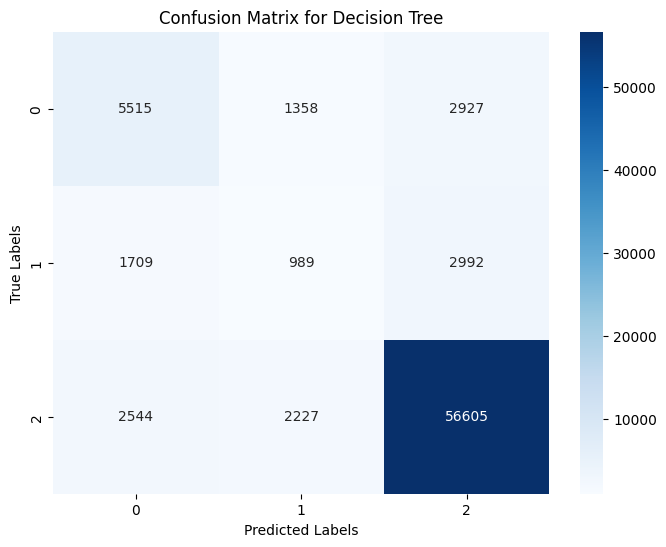


Evaluating Random Forest:
Random Forest Cross-Validation Accuracy: 0.8677 (+/- 0.0008)
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67      9800
           1       0.39      0.01      0.02      5690
           2       0.89      0.99      0.93     61376

    accuracy                           0.87     76866
   macro avg       0.67      0.54      0.54     76866
weighted avg       0.83      0.87      0.83     76866



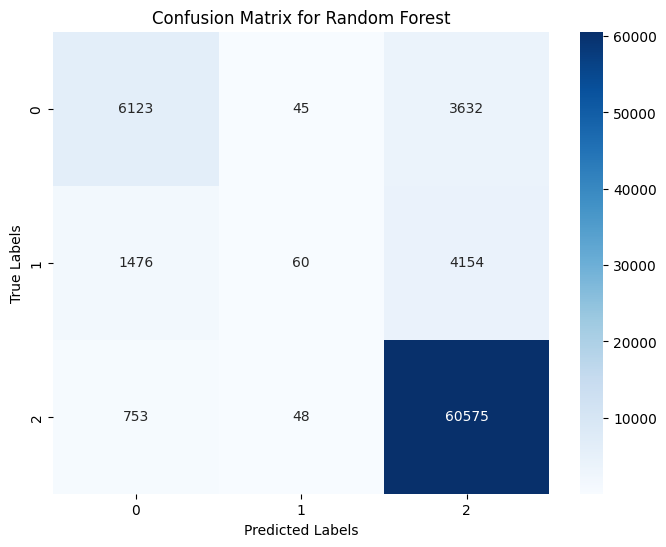

In [19]:
results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}:")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_combined, y_train_encoded, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

    # Train and evaluate
    model.fit(X_train_combined, y_train_encoded)
    y_pred = model.predict(X_test_combined)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    results[f"{model_name}"] = accuracy
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test_encoded, y_pred))

    # Confusion matrix
    cm_combined = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_encoded), yticklabels=np.unique(y_test_encoded))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


Overall Model Performance:
                 Model  Accuracy
1  Logistic Regression  0.879075
0        XGBClassifier  0.870697
4        Random Forest  0.868498
3        Decision Tree  0.821026
2          Naive Bayes  0.767934


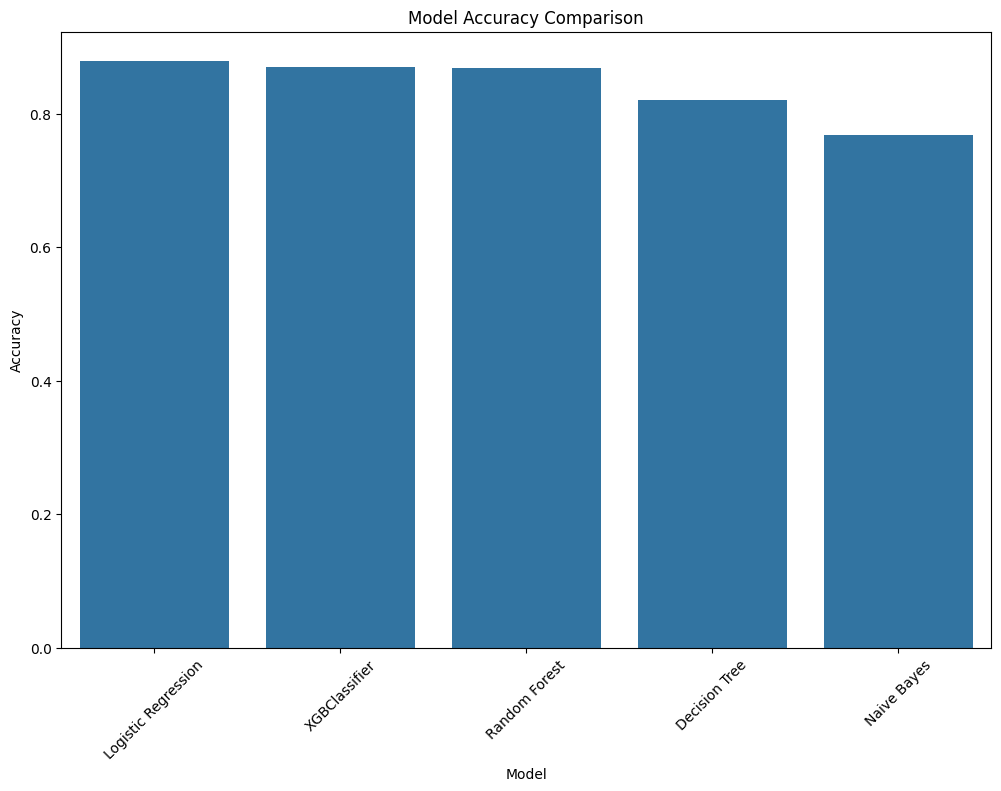

In [20]:
results_df = pd.DataFrame([{"Model": name, "Accuracy": acc} for name, acc in results.items()])
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

print("\nOverall Model Performance:")
print(results_df)
plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

In [21]:
model_save_path = "K:/Computer Science/AIMLDL/Brand_Reputation_Management_System/sentiment_analysis/model_building/models/"
os.makedirs(model_save_path, exist_ok=True)

for model_name, model in models.items():
    model_filename = os.path.join(model_save_path, f"{model_name}.pkl")
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"{model_name} saved to {model_filename}")

XGBClassifier saved to K:/Computer Science/AIMLDL/Brand_Reputation_Management_System/sentiment_analysis/model_building/models/XGBClassifier.pkl
Logistic Regression saved to K:/Computer Science/AIMLDL/Brand_Reputation_Management_System/sentiment_analysis/model_building/models/Logistic Regression.pkl
Naive Bayes saved to K:/Computer Science/AIMLDL/Brand_Reputation_Management_System/sentiment_analysis/model_building/models/Naive Bayes.pkl
Decision Tree saved to K:/Computer Science/AIMLDL/Brand_Reputation_Management_System/sentiment_analysis/model_building/models/Decision Tree.pkl
Random Forest saved to K:/Computer Science/AIMLDL/Brand_Reputation_Management_System/sentiment_analysis/model_building/models/Random Forest.pkl


In [15]:
results_df.to_csv('results.csv', index=False)
print(f"Results saved")

Results saved


In [16]:
results_df

,Model,Accuracy
0,XGBClassifier,0.870801
4,Random Forest,0.868941
2,Naive Bayes,0.846694
1,Logistic Regression,0.833216
3,Decision Tree,0.820974
